In [1]:
import os, time
import numpy as np
import matplotlib.pyplot as plt

from pynq import Overlay

import mkidgen3
from mkidgen3.drivers.ppssync import *
from mkidgen3.server.feedline_config import *
from mkidgen3.server.waveform import WaveformFactory
from mkidgen3.equipment_drivers.ifboard import IFBoard
import mkidgen3.plotting
from mkidgen3.plotting import plot_waveforms, plot_comp_sat, plot_ddc, plot_single_res_sweep
from mkidreadoutanalysis.mkidnoiseanalysis import plot_psd

from mkidgen3.util import rx_power, convert_freq_to_ddc_bins, pseudo_random_tones
from mkidgen3.power_sweep_helpers import get_iq_point, single_res_sweep, compute_lo_steps, get_iq_point
from mkidgen3.opfb import opfb_bin_number
from mkidgen3.mkid_setup.loop_locator import *
from mkidgen3.mkid_setup.sweeps import * 
import scipy.optimize as spo
import scipy.signal as sig


 <a class="anchor" id="table"></a>
# Table of Contents
* [0.System Setup](#setup)
    * [0.0.3 Tune Power](#power)
* [1. FPGA Direct Loopback](#fpga)
    * [1.1 Phase Noise in 1 Channel](#phase1)
* [2. IF Board Loopback](#if)
    * [2.1.1 Phase Noise in 1 Channel, 1 Tone](#phase2)
    * [2.2.1 Phase Noise in 1 Channel, 2048 Tones](#phase3)
* [3. Fridge Testing Parmp, Elson](#fridge)
    * [3.1.1 Single Resonator Setup, full DAC Dynamic Range](#fridge1)
    * [3.1.2 Single Resonator Setup, 1/200 DAC Dynamic Range](#fridge2)
    * [3.1.3 Single Resonator Setup, 1/200 DAC Dynamic Range, 2048 other uniform tones](#fridge3)
    * [3.1.4 Single Resonator Setup, 1/100 DAC Dynamic Range, 1024 other uniform tones](#fridge4)


# 0.0 Start Clocking, Download Bitstream  <a class="anchor" id="setup"></a>

In [2]:
# Set Board Timezone
os.environ['TZ'] = 'right/UTC'
time.tzset()

In [3]:
# Download Overlay, Optionally Configure Clocks
bitstream='/home/xilinx/gen3_top_final.bit'
mkidgen3.drivers.rfdcclock.configure(programming_key='4.096GSPS_MTS_dualloop',clock_source='external')
time.sleep(0.5)
ol = Overlay(bitstream, ignore_version=True, download=True)
mkidgen3.quirks.Overlay(ol).post_configure()

In [53]:
ol.rfdc.enable_mts()
ol.rfdc.enable_mts()

## 0.0.1 Start PPS SYNC

In [4]:
ol.pps_synchronization.pps_synchronizer_con_0.start_engine(PPSMode.FORCE_START, skew = 1000*1000*1000,
                                                                  clk_period_ns=1/256e-3)

## 0.0.2 IF Board Initial Settings (Max Attn & Off)

In [5]:
ifb = IFBoard()
ifb.power_off()
ifb.set_attens(output_attens=60, input_attens=60)
#ifb.set_lo(6010.0)
print(ifb.status())

IFStatus: Unpowered, boot 154. LO gen3 fractional mode, full calibration. PLL unlocked.
	Req: 4416.25 MHz Attained: None MHz Err: nan MHz
	DAC attens: (31.75, 28.25)
	ADC Attens: (28.25, 31.75)


## 0.0.3 Tune ADC Power  <a class="anchor" id="power"></a>

In [55]:
# Adjust IF Attn
ifb = IFBoard()
ifb.power_on()
ifb.set_attens(output_attens=3, input_attens=4)
ifb.set_lo(6000.0)
print(ifb.status())

IFStatus: Powered, boot 154. LO gen3 fractional mode, full calibration. PLL locked.
	Req: 6000 MHz Attained: 6000 MHz Err: 0 MHz
	DAC attens: (3.0, 0.0)
	ADC Attens: (0.0, 4.0)


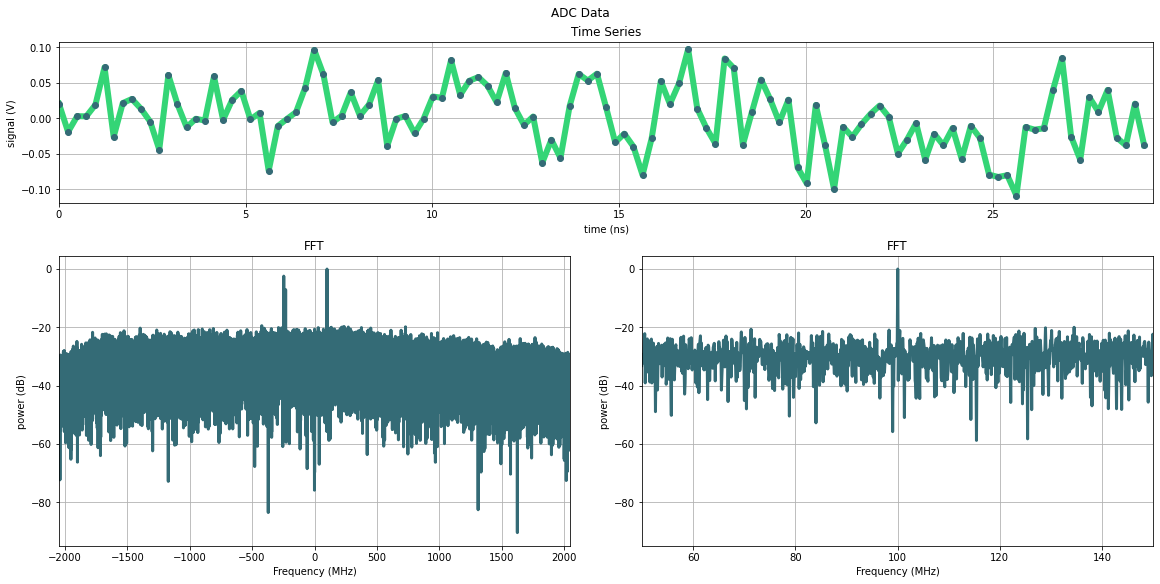

In [56]:
# Capture ADC
x = ol.capture.capture_adc(2**19, complex=False)  # throw away capture to clear any startup garbage
del x
adc_capture_data = ol.capture.capture_adc(2**19, complex=True)
adc_capture_data = adc_capture_data/2**15 # Normalize to 1/2 V
# Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096) 
fftzoom = (50, 150)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)

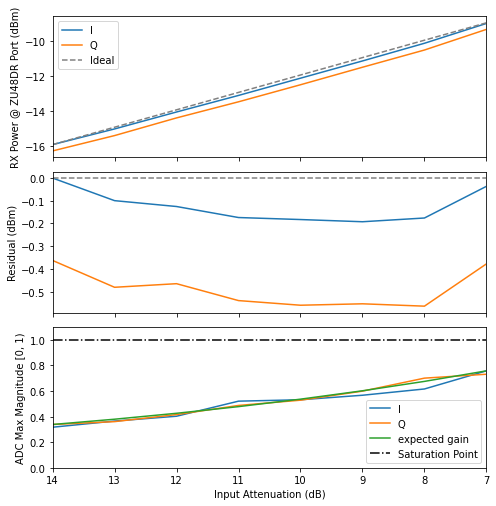

In [43]:
plot_comp_sat(ol, ifb, output_atten=0, input_range=(15, 7), figsize=(7, 7))
None

# 1.0 FPGA Direct Loopback Measurments  <a class="anchor" id="fpga"></a>
[Table of Contents](#table)

## Hardware Setup: Direct Loopback

<img src="img/direct_loopback.png" style="height:500px">

## 1.1.1 Single Tone, Full DAC Dynamic Range <a class="anchor" id="phase2"></a>

In [6]:
# Run DAC
tones = np.array([100e6])
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=tones, seed=6, dac_dynamic_range = 0.9, compute=True))
ol.dac_table.configure(**wvfm_cfg.settings_dict())

[0.0.3 Tune Power](#power)

In [39]:
# Bin2Res + DDC
chan = wvfm_cfg.default_channel_config
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())
ddc = wvfm_cfg.default_ddc_config
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

In [40]:
# Matched Filter
filtercfg=FilterConfig(coefficients=f'unity{2048}')
ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

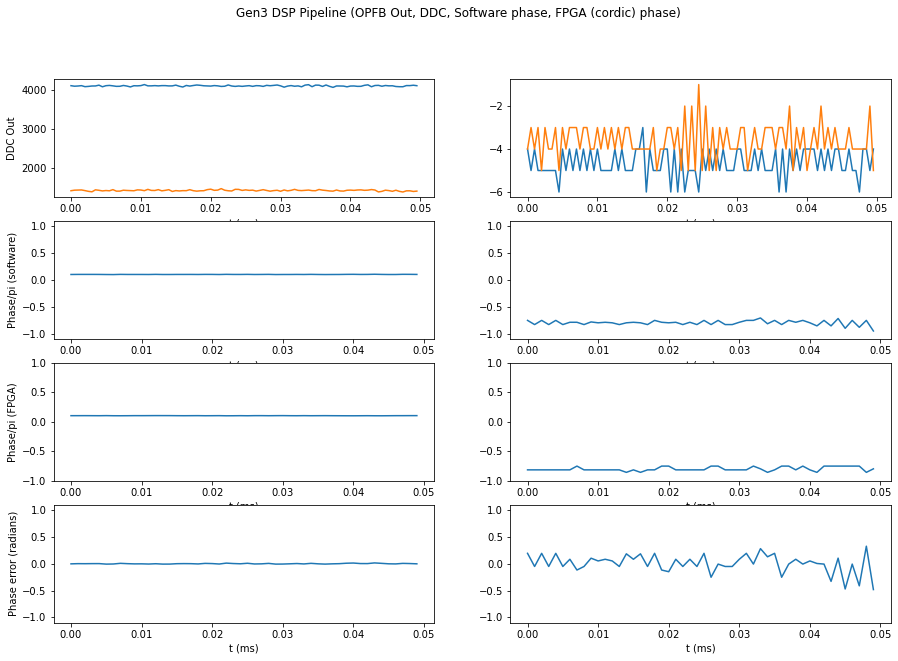

In [41]:
ddciq, phase = ol.capture.cap_cordic_compare()
chan_plt=[0,1]
plot_ddc(ddciq, phase, chan_plt)
None

In [42]:
# Capture Phase
x = ol.capture.capture_phase(2**19, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
phase0 = np.pi*phase[:,0]/(2**15-1)

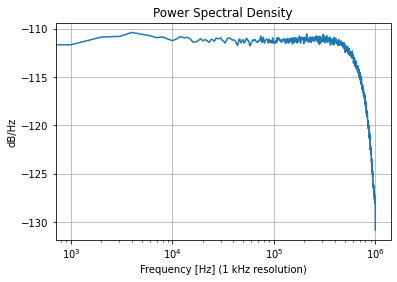

In [43]:
# Plot Phase PSD
plot_psd(phase0, fs=2e6, fres=1e3)

In [44]:
folder = '/nfs/wheatley/j_g3_data/'

for i in range(0,1):
    x = ol.capture.capture_phase(2**25, [0,1], tap_location='filtphase')
    phase = np.pi*x[:,0]/(2**15-1)
    x.freebuffer()
    file_name = f'if_loopback_singletone_phase{i:002d}.npz'
    np.savez(os.path.join(folder, file_name),phase_data=phase)
del phase

## 1.1.1 Single Tone,1/200 DAC Dynamic Range <a class="anchor" id="phase2"></a>

In [33]:
# Run DAC
tones = np.array([100e6])
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=tones, seed=6, dac_dynamic_range = 1/200, compute=True))
ol.dac_table.configure(**wvfm_cfg.settings_dict())

[0.0.3 Tune Power](#power)

In [45]:
# Bin2Res + DDC
chan = wvfm_cfg.default_channel_config
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())
ddc = wvfm_cfg.default_ddc_config
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

In [46]:
# Matched Filter
#filtercfg=FilterConfig(coefficients=f'unity{2048}')
#ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

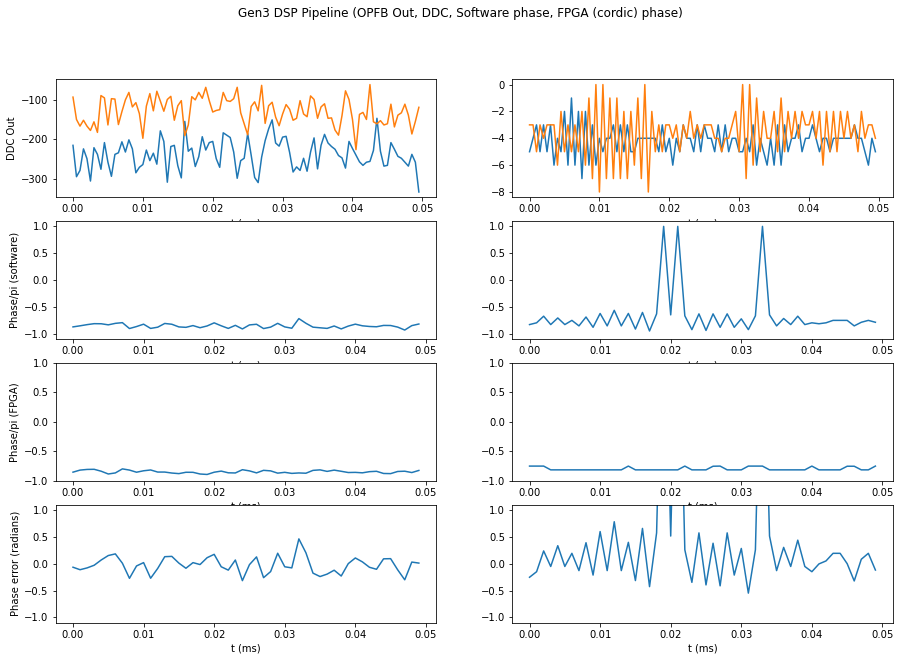

In [47]:
ddciq, phase = ol.capture.cap_cordic_compare()
chan_plt=[0,1]
plot_ddc(ddciq, phase, chan_plt)
None

In [48]:
# Capture Phase
x = ol.capture.capture_phase(2**19, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
phase0 = np.pi*phase[:,0]/(2**15-1)

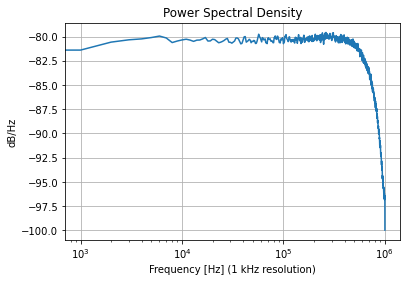

In [49]:
# Plot Phase PSD
plot_psd(phase0, fs=2e6, fres=1e3)

In [50]:
folder = '/nfs/wheatley/j_g3_data/'

for i in range(0,1):
    x = ol.capture.capture_phase(2**25, [0,1], tap_location='filtphase')
    phase = np.pi*x[:,0]/(2**15-1)
    x.freebuffer()
    file_name = f'if_loopback_singletone_smalldr_phase{i:002d}.npz'
    np.savez(os.path.join(folder, file_name),phase_data=phase)
del phase

## 1.1.2 2048 Tones, Realistic Fraction of DAC Dynamic Range <a class="anchor" id="phase3"></a>

In [9]:
from mkidgen3.system_parameters import OPFB_CHANNEL_SAMPLE_RATE, ADC_SAMPLE_RATE, N_OPFB_CHANNELS
buffer=300e3
spread=True
n=2048

opfb_halfband = OPFB_CHANNEL_SAMPLE_RATE / 2
rand_offsets = np.random.uniform(low=buffer-opfb_halfband, high=opfb_halfband/2-buffer,
                                    size=n-1)
bc = (ADC_SAMPLE_RATE / N_OPFB_CHANNELS) * np.linspace(-N_OPFB_CHANNELS / 2, N_OPFB_CHANNELS / 2 - 1,
                                                                    N_OPFB_CHANNELS)
if spread:
    bc = bc[::2]
tone_bin_centers = np.concatenate((bc[bc.size//2-n//2:bc.size//2], bc[bc.size//2+1:+bc.size//2+n//2+1]))
tones = tone_bin_centers + rand_offsets

In [13]:
tones.shape

(2047,)

In [14]:
# Run DAC
#tones = pseudo_random_tones(2048)
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=tones, seed=4, dac_dynamic_range = 0.95, compute=True))
tones = wvfm_cfg.waveform.quant_freqs
ol.dac_table.configure(**wvfm_cfg.settings_dict())

In [23]:
# We're going to focus on reading out this one tone around 100 MHz
ro_tone = tones[tones.size//2+100]

[0.0.3 Tune Power](#power)

Since we are running a lot of tones we will only program bin2res and the DDC to readout 1 to conserve some power for these tests. I beleive this is legit because there should be no leakage / crosstalk in the channels after the OPFB.

In [24]:
# Bin2Res + DDC
empty_bin = opfb_bin_number(tones.max() + 100e6, ssr_raw_order=True)
bins = np.zeros(2048, dtype=int)+empty_bin
bins[0] = opfb_bin_number(ro_tone, ssr_raw_order=True)

chan = ChannelConfig(bins=bins)
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())

ddc_tones = np.zeros(2048)
ddc_tones[0] = ro_tone

ddc = DDCConfig(tones=ddc_tones)
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

In [25]:
#ol.photon_pipe.reschan.ddccontrol_0.reset_phase_center()

In [28]:
# Matched Filter
#filtercfg=FilterConfig(coefficients=f'unity{2048}')
#ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

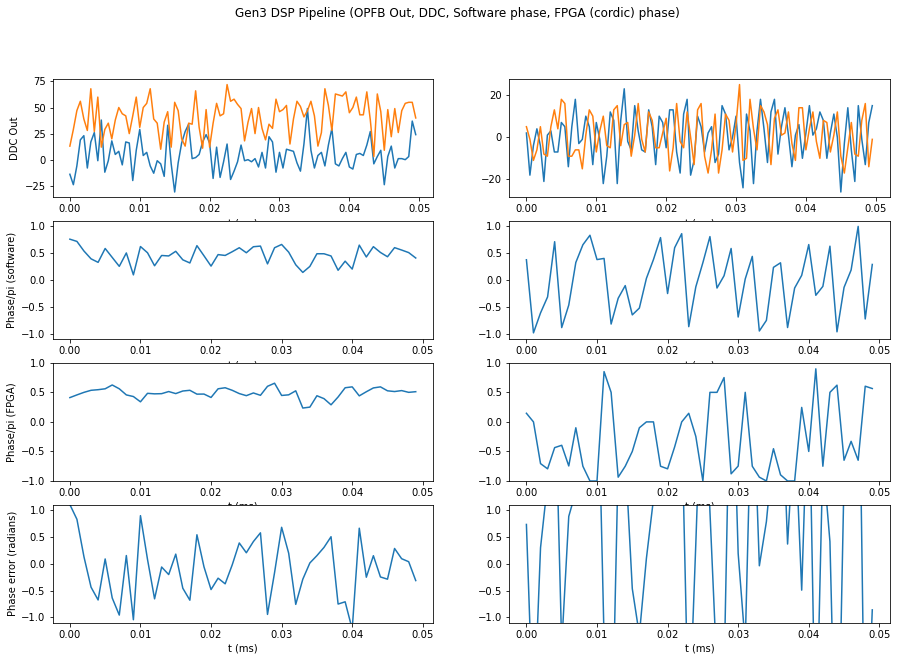

In [29]:
ddciq, phase = ol.capture.cap_cordic_compare()
chan_plt=[0,1]
plot_ddc(ddciq, phase, chan_plt)
None

In [30]:
# Capture Phase
x = ol.capture.capture_phase(2**19, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
phase0 = np.pi*phase[:,0]/(2**15-1)

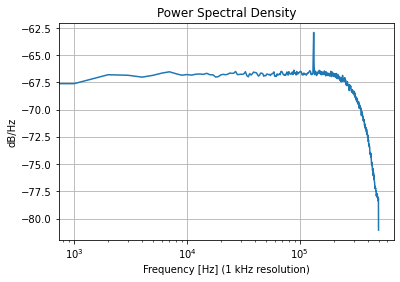

In [31]:
# Plot Phase PSD
plot_psd(phase0, fs=1e6, fres=1e3)

In [32]:
folder = '/nfs/wheatley/j_g3_data/'

for i in range(0,1):
    x = ol.capture.capture_phase(2**25, [0,1], tap_location='filtphase')
    phase = np.pi*x[:,0]/(2**15-1)
    x.freebuffer()
    file_name = f'if_loopback_2000tones_phase{i:002d}.npz'
    np.savez(os.path.join(folder, file_name),phase_data=phase)
del phase

# 2.0 IF Board Loopback Measurments  <a class="anchor" id="if"></a>
[Table of Contents](#table)

## Hardware Setup: IF Board Loopback w/ 30 dB attn

<img src="img/if_loopback.png" style="height:500px">

## 2.1.1 Single Tone, Full DAC Dynamic Range <a class="anchor" id="phase2"></a>

In [6]:
# Run DAC
tones = np.array([100e6])
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=tones, seed=6, dac_dynamic_range = 0.9, compute=True))
ol.dac_table.configure(**wvfm_cfg.settings_dict())

[0.0.3 Tune Power](#power)

In [39]:
# Bin2Res + DDC
chan = wvfm_cfg.default_channel_config
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())
ddc = wvfm_cfg.default_ddc_config
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

In [40]:
# Matched Filter
filtercfg=FilterConfig(coefficients=f'unity{2048}')
ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

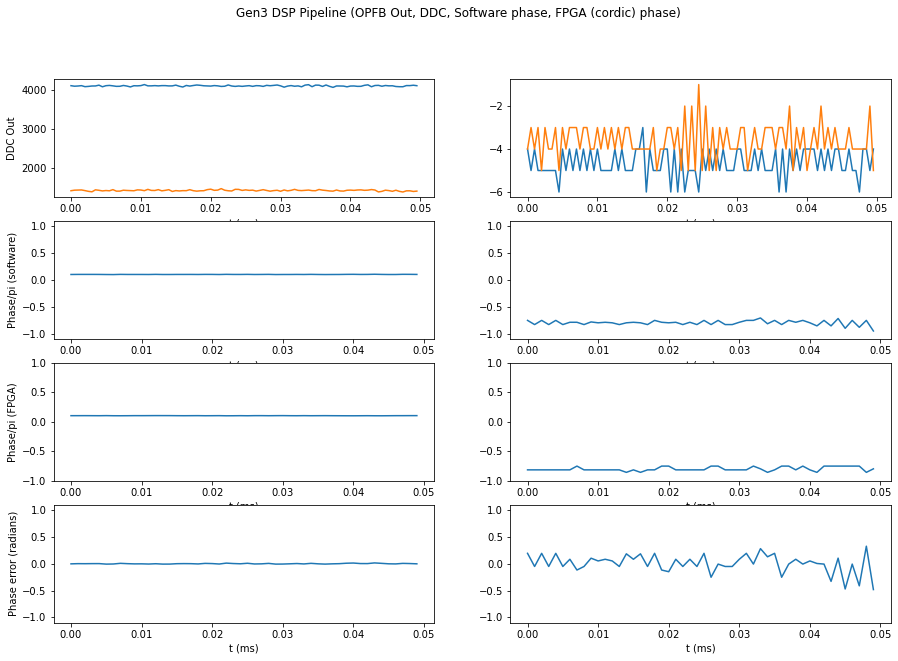

In [41]:
ddciq, phase = ol.capture.cap_cordic_compare()
chan_plt=[0,1]
plot_ddc(ddciq, phase, chan_plt)
None

In [42]:
# Capture Phase
x = ol.capture.capture_phase(2**19, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
phase0 = np.pi*phase[:,0]/(2**15-1)

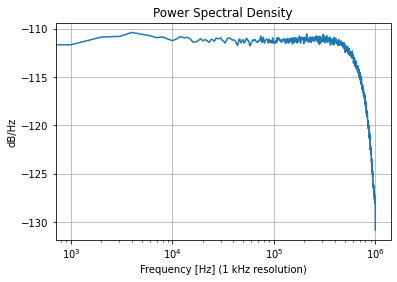

In [43]:
# Plot Phase PSD
plot_psd(phase0, fs=2e6, fres=1e3)

In [44]:
folder = '/nfs/wheatley/j_g3_data/'

for i in range(0,1):
    x = ol.capture.capture_phase(2**25, [0,1], tap_location='filtphase')
    phase = np.pi*x[:,0]/(2**15-1)
    x.freebuffer()
    file_name = f'if_loopback_singletone_phase{i:002d}.npz'
    np.savez(os.path.join(folder, file_name),phase_data=phase)
del phase

## 2.1.1 Single Tone,1/200 DAC Dynamic Range <a class="anchor" id="phase2"></a>

In [33]:
# Run DAC
tones = np.array([100e6])
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=tones, seed=6, dac_dynamic_range = 1/200, compute=True))
ol.dac_table.configure(**wvfm_cfg.settings_dict())

[0.0.3 Tune Power](#power)

In [45]:
# Bin2Res + DDC
chan = wvfm_cfg.default_channel_config
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())
ddc = wvfm_cfg.default_ddc_config
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

In [46]:
# Matched Filter
#filtercfg=FilterConfig(coefficients=f'unity{2048}')
#ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

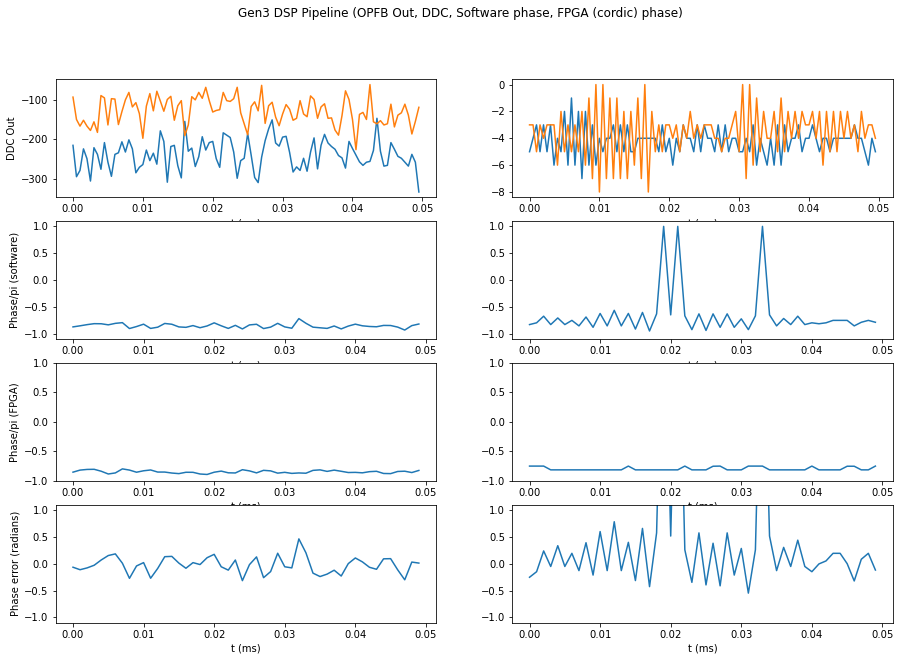

In [47]:
ddciq, phase = ol.capture.cap_cordic_compare()
chan_plt=[0,1]
plot_ddc(ddciq, phase, chan_plt)
None

In [48]:
# Capture Phase
x = ol.capture.capture_phase(2**19, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
phase0 = np.pi*phase[:,0]/(2**15-1)

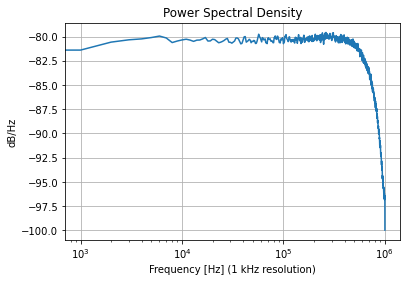

In [49]:
# Plot Phase PSD
plot_psd(phase0, fs=2e6, fres=1e3)

In [50]:
folder = '/nfs/wheatley/j_g3_data/'

for i in range(0,1):
    x = ol.capture.capture_phase(2**25, [0,1], tap_location='filtphase')
    phase = np.pi*x[:,0]/(2**15-1)
    x.freebuffer()
    file_name = f'if_loopback_singletone_smalldr_phase{i:002d}.npz'
    np.savez(os.path.join(folder, file_name),phase_data=phase)
del phase

## 2.1.2 2048 Tones, Realistic Fraction of DAC Dynamic Range <a class="anchor" id="phase3"></a>

In [9]:
from mkidgen3.system_parameters import OPFB_CHANNEL_SAMPLE_RATE, ADC_SAMPLE_RATE, N_OPFB_CHANNELS
buffer=300e3
spread=True
n=2048

opfb_halfband = OPFB_CHANNEL_SAMPLE_RATE / 2
rand_offsets = np.random.uniform(low=buffer-opfb_halfband, high=opfb_halfband/2-buffer,
                                    size=n-1)
bc = (ADC_SAMPLE_RATE / N_OPFB_CHANNELS) * np.linspace(-N_OPFB_CHANNELS / 2, N_OPFB_CHANNELS / 2 - 1,
                                                                    N_OPFB_CHANNELS)
if spread:
    bc = bc[::2]
tone_bin_centers = np.concatenate((bc[bc.size//2-n//2:bc.size//2], bc[bc.size//2+1:+bc.size//2+n//2+1]))
tones = tone_bin_centers + rand_offsets

In [13]:
tones.shape

(2047,)

In [14]:
# Run DAC
#tones = pseudo_random_tones(2048)
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=tones, seed=4, dac_dynamic_range = 0.95, compute=True))
tones = wvfm_cfg.waveform.quant_freqs
ol.dac_table.configure(**wvfm_cfg.settings_dict())

In [23]:
# We're going to focus on reading out this one tone around 100 MHz
ro_tone = tones[tones.size//2+100]

[0.0.3 Tune Power](#power)

Since we are running a lot of tones we will only program bin2res and the DDC to readout 1 to conserve some power for these tests. I beleive this is legit because there should be no leakage / crosstalk in the channels after the OPFB.

In [24]:
# Bin2Res + DDC
empty_bin = opfb_bin_number(tones.max() + 100e6, ssr_raw_order=True)
bins = np.zeros(2048, dtype=int)+empty_bin
bins[0] = opfb_bin_number(ro_tone, ssr_raw_order=True)

chan = ChannelConfig(bins=bins)
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())

ddc_tones = np.zeros(2048)
ddc_tones[0] = ro_tone

ddc = DDCConfig(tones=ddc_tones)
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

In [25]:
#ol.photon_pipe.reschan.ddccontrol_0.reset_phase_center()

In [28]:
# Matched Filter
#filtercfg=FilterConfig(coefficients=f'unity{2048}')
#ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

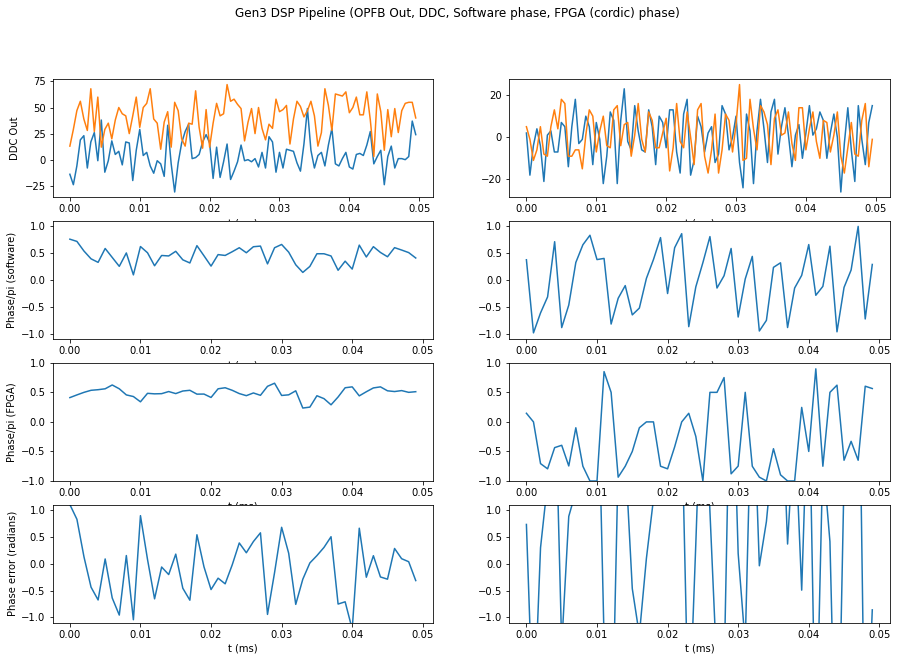

In [29]:
ddciq, phase = ol.capture.cap_cordic_compare()
chan_plt=[0,1]
plot_ddc(ddciq, phase, chan_plt)
None

In [30]:
# Capture Phase
x = ol.capture.capture_phase(2**19, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
phase0 = np.pi*phase[:,0]/(2**15-1)

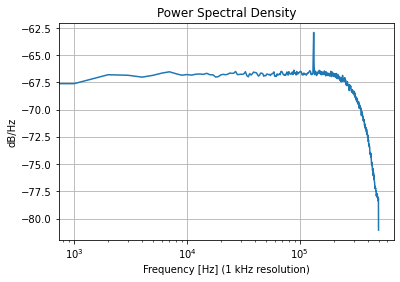

In [31]:
# Plot Phase PSD
plot_psd(phase0, fs=1e6, fres=1e3)

In [32]:
folder = '/nfs/wheatley/j_g3_data/'

for i in range(0,1):
    x = ol.capture.capture_phase(2**25, [0,1], tap_location='filtphase')
    phase = np.pi*x[:,0]/(2**15-1)
    x.freebuffer()
    file_name = f'if_loopback_2000tones_phase{i:002d}.npz'
    np.savez(os.path.join(folder, file_name),phase_data=phase)
del phase

# 3.0 Fridge: Paramp + HEMT MKID Measurments  <a class="anchor" id="fridge"></a>

[Table of Contents](#table)

## Hardware Setup: Connected to WhiteFridge Elson Feedline 2

<img src="img/fridge.png" style="height:500px">

## 3.1.1 Single Resonator Setup, Full DAC Dynamic Range <a class="anchor" id="fridge1"></a>
[Table of Contents](#table)

In [39]:
# Run DAC
tones = np.array([100e6])
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=tones, seed=6, dac_dynamic_range = 0.9, compute=True))
ol.dac_table.configure(**wvfm_cfg.settings_dict())

In [40]:
# Bin2Res + DDC
chan = wvfm_cfg.default_channel_config
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())
ddc = wvfm_cfg.default_ddc_config
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

#### Coarse Power Adjustment

[0.0.3 Tune Power](#power)

In [50]:
res_freq = 4516.25
lo_cen = res_freq - tones[0]*1e-6

In [100]:
capture = ol.capture
ddccontrol = ol.photon_pipe.reschan.ddccontrol_0

sweep = sweepconfig = SweepConfig.from_bandwidth(
    bandwidth = 1e6,
    points=128,
    average=128,
    waveform=wvfm_cfg,
    lo_center=lo_cen
).reset_ddc(ddccontrol).run_sweep(ifboard=ifb, capture = capture)

FREQ:   0%|          | 0/128 [00:00<?, ?it/s]

In [101]:
ifb.set_lo(lo_cen)
iq_val_res = get_iq_point(ol)

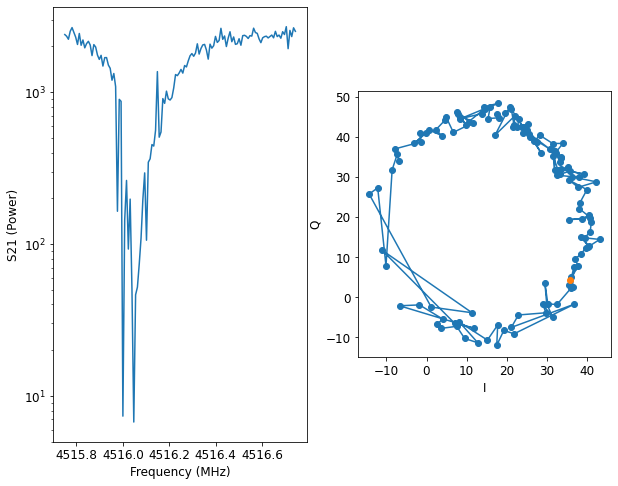

In [102]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10, 8))
sweep.plot(ax0)
sweep.plot_loops(ax1)
ax1.plot(iq_val_res.real, iq_val_res.imag, "o")

In [98]:
# Fine Power Adjustment
ifb = IFBoard()
ifb.power_on()
ifb.set_attens(output_attens=53, input_attens=23)
print(ifb.status())

IFStatus: Powered, boot 153. LO gen3 fractional mode, full calibration. PLL locked.
	Req: 6000 MHz Attained: 6000 MHz Err: 0 MHz
	DAC attens: (31.75, 21.25)
	ADC Attens: (0.0, 23.0)


In [103]:
# Rotate and Center
rotate_and_center(sweep, targets = [0], program = ddccontrol)

(<mkidgen3.server.feedline_config.DDCConfig at 0xffff1e369cf0>,
 (12.544100392015498, 18.223091751534216),
 26.561155846586473)

In [104]:
# Re-Sweep
# Note, we do not reset ddc here:
sweep = sweepconfig = SweepConfig.from_bandwidth(
    bandwidth = 1e6,
    points=128,
    average=128,
    waveform=wvfm_cfg,
    lo_center=lo_cen
).run_sweep(ifboard=ifb, capture = capture)
ifb.set_lo(lo_cen)
iq_val_res = get_iq_point(ol)

FREQ:   0%|          | 0/128 [00:00<?, ?it/s]

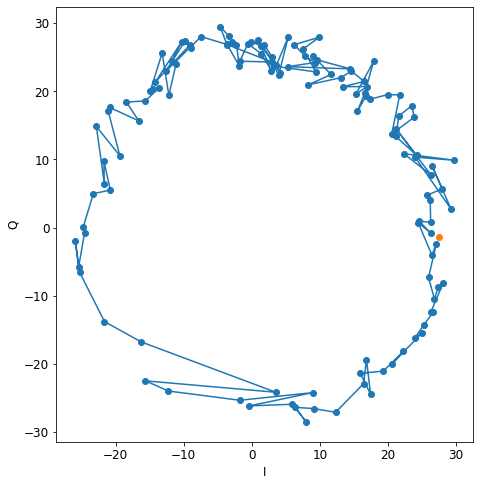

In [105]:
fig, ax = plt.subplots(1, figsize = (8, 8))
sweep.plot_loops(ax)
ax.plot(iq_val_res.real, iq_val_res.imag, "o")

In [76]:
# Unity Filter
filtercfg=FilterConfig(coefficients=f'unity{2048}')
ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

In [106]:
x = ol.capture.capture_phase(2**12, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
laser_on = np.pi*phase[:,0]/(2**15)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 4096.0)

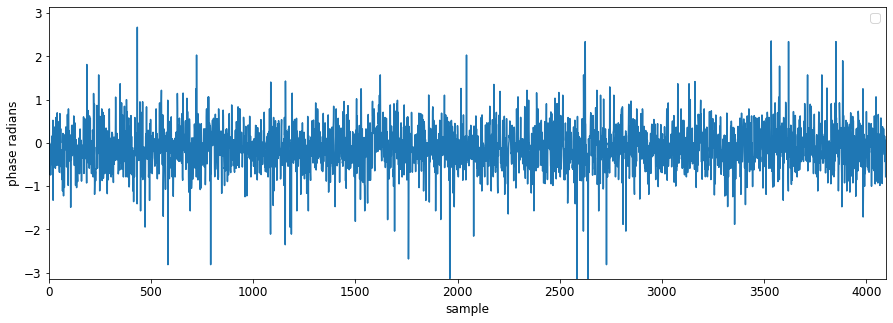

In [107]:
# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.rcParams.update({'font.size': 12})

ax1.plot(laser_on)#, label='laser on')
#ax1.plot(laser_off, label='laser off')
ax1.set_ylabel('phase radians')
ax1.set_xlabel('sample')
ax1.legend(loc = 'upper right')
ax1.set_ylim([-np.pi,np.pi])
ax1.set_xlim(0,4096)

In [27]:
# Take Matched Filter Data
folder = '/nfs/wheatley/j_whitefrige_data_03_05_24/ofilt_single_res'

for i in range(0,1):
    x = ol.capture.capture_phase(2**25, [0,1], tap_location='filtphase')
    phase = np.pi*x[:,0]/(2**15-1)
    x.freebuffer()
    file_name = f'wf_ellison_6_682522_GHz_single_tone_fulldr_phase{i:002d}.npz'
    np.savez(os.path.join(folder, file_name),phase_data=phase)
del phase

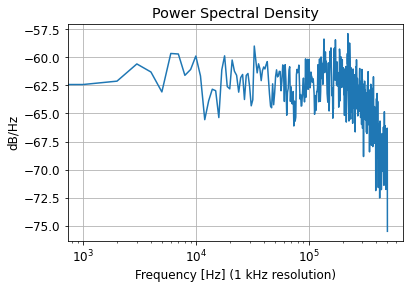

In [108]:
# Plot Phase PSD
plot_psd(laser_on, fs=1e6, fres=1e3)

## 3.1.2 Single Resonator Setup, 1/200 DAC Dynamic Range <a class="anchor" id="fridge2"></a>
[Table of Contents](#table)

In [6]:
# Run DAC
tones = np.array([100e6])
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=tones, seed=6, dac_dynamic_range = 1.0/200, compute=True))
ol.dac_table.configure(**wvfm_cfg.settings_dict())

In [7]:
# Bin2Res + DDC
chan = wvfm_cfg.default_channel_config
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())
ddc = wvfm_cfg.default_ddc_config
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

In [8]:
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

#### Coarse Power Adjustment

[0.0.3 Tune Power](#power)

In [70]:
res_freq = 6682.530
lo_cen = res_freq - tones[0]*1e-6

In [71]:
capture = ol.capture
ddccontrol = ol.photon_pipe.reschan.ddccontrol_0

sweep = sweepconfig = SweepConfig.from_bandwidth(
    bandwidth = 1e6,
    points=128,
    average=2048,
    waveform=wvfm_cfg,
    lo_center=lo_cen
).reset_ddc(ddccontrol).run_sweep(ifboard=ifb, capture = capture)

FREQ:   0%|          | 0/128 [00:00<?, ?it/s]

In [72]:
ifb.set_lo(lo_cen)
iq_val_res = get_iq_point(ol)

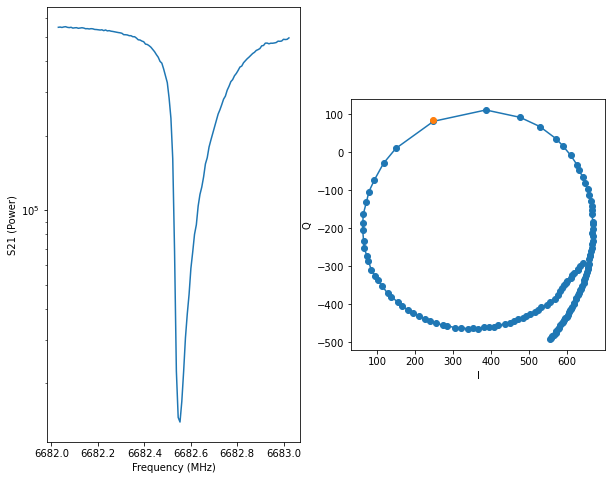

In [73]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10, 8))
sweep.plot(ax0)
sweep.plot_loops(ax1)
ax1.plot(iq_val_res.real, iq_val_res.imag, "o")

In [42]:
# Fine Power Adjustment
ifb = IFBoard()
ifb.power_on()
ifb.set_attens(output_attens=0, input_attens=50)
print(ifb.status())

IFStatus: Powered, boot 152. LO gen3 fractional mode, full calibration. PLL locked.
	Req: 6582.722 MHz Attained: 6582.722 MHz Err: 0.0 MHz
	DAC attens: (0.0, 0.0)
	ADC Attens: (18.25, 31.75)


In [74]:
# Rotate and Center
rotate_and_center(sweep, targets = [0], program = ddccontrol)

(<mkidgen3.server.feedline_config.DDCConfig at 0xffff385eb760>,
 (375.22793000533414, -182.2588699288782),
 292.6058605693059)

In [75]:
# Re-Sweep
# Note, we do not reset ddc here:
sweep = sweepconfig = SweepConfig.from_bandwidth(
    bandwidth = 1e6,
    points=128,
    average=2048,
    waveform=wvfm_cfg,
    lo_center=lo_cen
).run_sweep(ifboard=ifb, capture = capture)
ifb.set_lo(lo_cen)
iq_val_res = get_iq_point(ol)

FREQ:   0%|          | 0/128 [00:00<?, ?it/s]

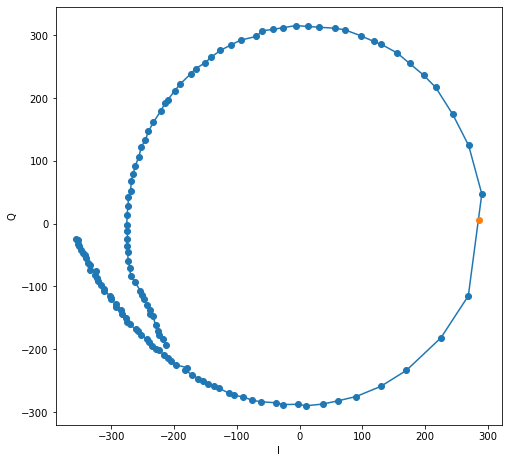

In [76]:
fig, ax = plt.subplots(1, figsize = (8, 8))
sweep.plot_loops(ax)
ax.plot(iq_val_res.real, iq_val_res.imag, "o")

In [77]:
# Unity Filter
filtercfg=FilterConfig(coefficients=f'unity{2048}')
ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

In [80]:
x = ol.capture.capture_phase(2**19, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
laser_on = np.pi*phase[:,0]/(2**15)

(0.0, 10000.0)

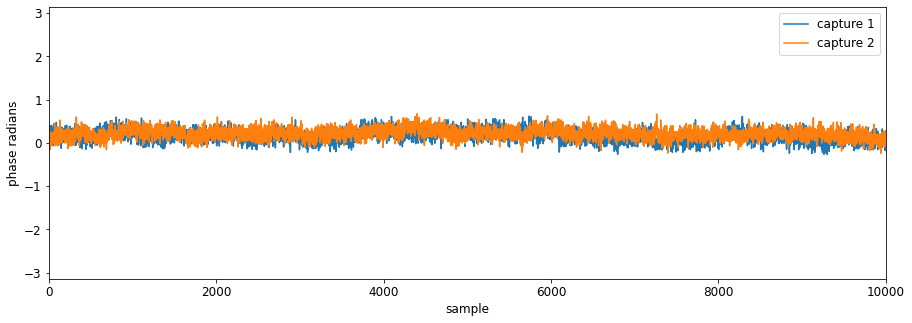

In [81]:
# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.rcParams.update({'font.size': 12})

ax1.plot(laser_on, label='capture 1')
ax1.plot(laser_off, label='capture 2')
ax1.set_ylabel('phase radians')
ax1.set_xlabel('sample')
ax1.legend(loc = 'upper right')
ax1.set_ylim([-np.pi,np.pi])
ax1.set_xlim(0,10000)

In [ ]:
# Take Matched Filter Data
folder = '/nfs/wheatley/j_whitefrige_data_03_05_24/ofilt_single_res'

for i in range(0,1):
    x = ol.capture.capture_phase(2**25, [0,1], tap_location='filtphase')
    phase = np.pi*x[:,0]/(2**15-1)
    x.freebuffer()
    file_name = f'wf_ellison_6_682522_GHz_single_tone_2048dr_phase{i:002d}.npz'
    np.savez(os.path.join(folder, file_name),phase_data=phase)
del phase

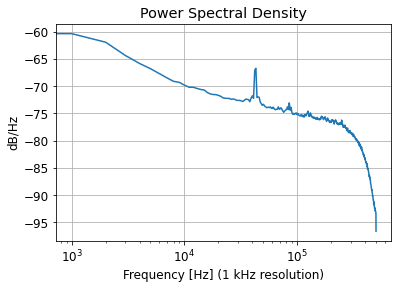

In [82]:
# Plot Phase PSD
plot_psd(laser_on, fs=1e6, fres=1e3)

## 3.1.3 Single Resonator Setup, ~1/200 DAC Dynamic Range, 2048 other uniform <a class="anchor" id="fridge3"></a>
[Table of Contents](#table)

In [6]:
# Run DAC
tones = pseudo_random_tones(2048)
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=tones, seed=6, dac_dynamic_range = 0.95, compute=True))
tones = wvfm_cfg.waveform.quant_freqs
ol.dac_table.configure(**wvfm_cfg.settings_dict())

In [7]:
# We're going to focus on reading out this one tone around 100 MHz
ro_tone = tones[tones.size//2+100]

In [8]:
# Bin2Res + DDC
empty_bin = opfb_bin_number(tones.max() + 100e6, ssr_raw_order=True)
bins = np.zeros(2048, dtype=int)+empty_bin
bins[0] = opfb_bin_number(ro_tone, ssr_raw_order=True)

chan = ChannelConfig(bins=bins)
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())

ddc_tones = np.zeros(2048)
ddc_tones[0] = ro_tone

ddc = DDCConfig(tones=ddc_tones)
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

#### Coarse Power Adjustment

[0.0.3 Tune Power](#power)

In [96]:
res_freq = 6682.526 # decrease to go counter clockwise
lo_cen = res_freq - ro_tone*1e-6

In [78]:
capture = ol.capture
ddccontrol = ol.photon_pipe.reschan.ddccontrol_0

sweep = sweepconfig = SweepConfig.from_bandwidth(
    bandwidth = 1e6,
    points=128,
    average=2048,
    waveform=wvfm_cfg,
    lo_center=lo_cen
).reset_ddc(ddccontrol).run_sweep(ifboard=ifb, capture = capture)

FREQ:   0%|          | 0/128 [00:00<?, ?it/s]

In [97]:
ifb.set_lo(lo_cen)
iq_val_res = get_iq_point(ol)

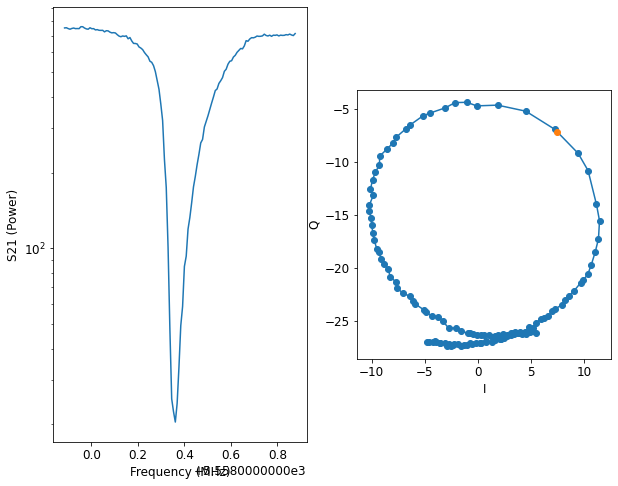

In [98]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10, 8))
sweep.plot(ax=ax0, channels=slice(0,1))
sweep.plot_loops(ax=ax1, channels=slice(0,1))
ax1.plot(iq_val_res.real, iq_val_res.imag, "o")

In [44]:
# Fine Power Adjustment
ifb = IFBoard()
ifb.power_on()
ifb.set_attens(output_attens=3, input_attens=43)
print(ifb.status())

IFStatus: Powered, boot 152. LO gen3 fractional mode, full calibration. PLL locked.
	Req: 6582.125 MHz Attained: 6582.125 MHz Err: 0.0 MHz
	DAC attens: (3.0, 0.0)
	ADC Attens: (11.25, 31.75)


In [99]:
# Rotate and Center
rotate_and_center(sweep, targets = [0], program = ddccontrol)

(<mkidgen3.server.feedline_config.DDCConfig at 0xffff33732440>,
 (0.6823727239847406, -15.188980501002707),
 11.063273799112752)

In [100]:
# Re-Sweep
# Note, we do not reset ddc here:
sweep = sweepconfig = SweepConfig.from_bandwidth(
    bandwidth = 1e6,
    points=128,
    average=2048,
    waveform=wvfm_cfg,
    lo_center=lo_cen
).run_sweep(ifboard=ifb, capture = capture)
ifb.set_lo(lo_cen)
iq_val_res = get_iq_point(ol)

FREQ:   0%|          | 0/128 [00:00<?, ?it/s]

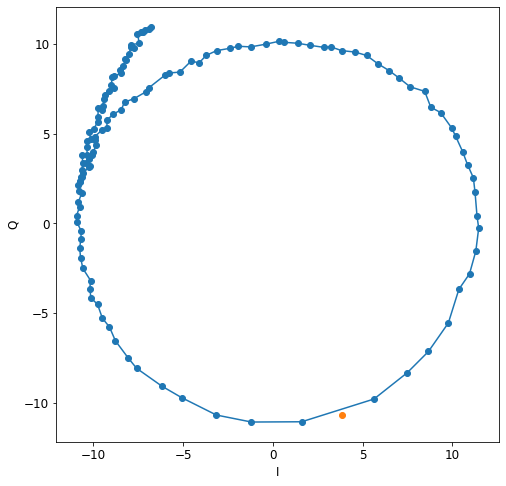

In [101]:
fig, ax = plt.subplots(1, figsize = (8, 8))
sweep.plot_loops(ax, channels=slice(0,1))
ax.plot(iq_val_res.real, iq_val_res.imag, "o")

In [102]:
# Unity Filter
filtercfg=FilterConfig(coefficients=f'unity{2048}')
ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

In [104]:
x = ol.capture.capture_phase(2**19, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
laser_on = np.pi*phase[:,0]/(2**15)

(0.0, 10000.0)

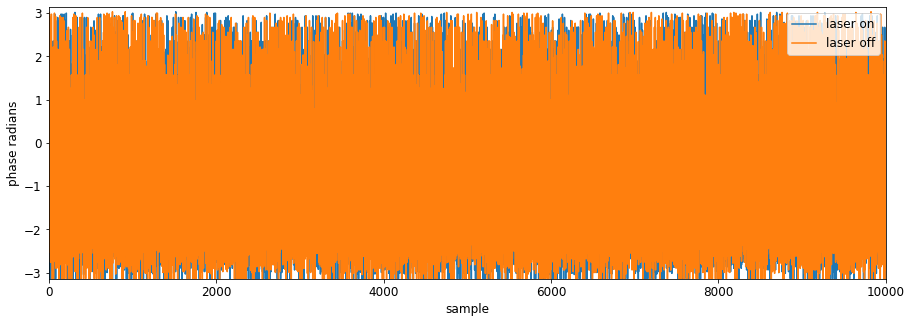

In [105]:
# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.rcParams.update({'font.size': 12})

ax1.plot(laser_on, label='laser on')
ax1.plot(laser_off, label='laser off')
ax1.set_ylabel('phase radians')
ax1.set_xlabel('sample')
ax1.legend(loc = 'upper right')
ax1.set_ylim([-np.pi,np.pi])
ax1.set_xlim(0,10000)

In [ ]:
# Take Matched Filter Data
folder = '/nfs/wheatley/j_whitefrige_data_03_05_24/ofilt_single_res'

for i in range(0,1):
    x = ol.capture.capture_phase(2**25, [0,1], tap_location='filtphase')
    phase = np.pi*x[:,0]/(2**15-1)
    x.freebuffer()
    file_name = f'wf_ellison_6_682522_GHz_2048tones_2048dr_phase{i:002d}.npz'
    np.savez(os.path.join(folder, file_name),phase_data=phase)
del phase

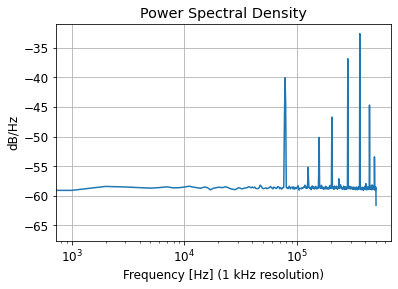

In [106]:
# Plot Phase PSD
plot_psd(laser_on, fs=1e6, fres=1e3)

## 3.1.4 Single Resonator Setup, 1/1024 DAC Dynamic Range, 1024 other uniform tones <a class="anchor" id="fridge4"></a>
[Table of Contents](#table)